In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

In [5]:
data_dir = '/kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data'
Name = os.listdir(data_dir)
print(Name)

['N', '7', 'R', '2', 'B', 'I', 'F', '_', 'H', '5', 'E', 'U', 'M', '8', 'X', '0', 'K', 'Q', 'Y', 'S', 'G', 'A', 'O', 'T', 'V', 'Z', '3', '1', 'C', '4', 'P', '9', 'L', '6', 'W', 'D', 'J']


In [6]:
N = list(range(len(Name)))
normal_mapping = dict(zip(Name,N)) 
reverse_mapping = dict(zip(N,Name)) 

(50, 50, 3)


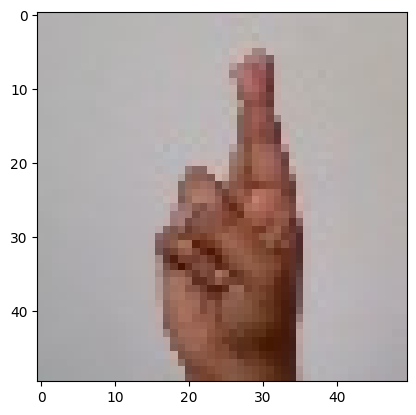

In [7]:
path_to_a_random_image = '/kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/R/1.jpg'
image=cv2.imread(path_to_a_random_image)
print(image.shape)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [8]:
dataset = []
dataname = []

count=0

for name in tqdm(os.listdir(data_dir)):
    
    path=os.path.join(data_dir,name)
    
    for im in os.listdir(path):
        image=cv2.imread(os.path.join(path,im))
        dataset += [image]
        dataname += [count]
    
    count=count+1 

100%|██████████| 37/37 [07:33<00:00, 12.25s/it]


In [9]:
data = np.array(dataset)
dataname = np.array(dataname)

In [10]:
print(pd.Series(dataname).value_counts())

0     1500
1     1500
2     1500
3     1500
4     1500
5     1500
6     1500
7     1500
8     1500
9     1500
10    1500
11    1500
12    1500
13    1500
14    1500
15    1500
16    1500
17    1500
18    1500
19    1500
20    1500
21    1500
22    1500
23    1500
24    1500
25    1500
26    1500
27    1500
28    1500
29    1500
30    1500
31    1500
32    1500
33    1500
34    1500
35    1500
36    1500
Name: count, dtype: int64


In [11]:
data_length = len(data)  #m
M = list(range(data_length))
random.seed(2021)
random.shuffle(M)

In [12]:
# Define the indices for splitting data (train and test split)
train_index = M[0:(data_length // 4) * 3]  
test_index = M[(data_length // 4) * 3:]   

# Split data into training and testing sets
train_features = data[train_index]
train_labels = dataname[train_index]

test_features = data[test_index]
test_labels = dataname[test_index]

In [13]:
# Convert training labels to categorical and create numpy array
train_labels_categorical = to_categorical(train_labels)
train_labels_array = np.array(train_labels_categorical)

In [14]:
train_labels_categorical

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
train_labels_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
# Split training data into train and validation sets
trainX, valX, trainY, valY = train_test_split(train_features, train_labels_array, test_size=0.2, random_state=42)

In [17]:
# Create an ImageDataGenerator for data augmentation

data_generator = ImageDataGenerator(
    horizontal_flip=True,      # Randomly flip input images horizontally
    vertical_flip=True,        # Randomly flip input images vertically
    rotation_range=20,         # Rotate images up to 20 degrees
    zoom_range=(0.8, 1.2),     # Randomly zoom in and out by up to 20%
    width_shift_range=0.2,     # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,    # Shift images vertically by up to 20% of the height
    shear_range=0.1,           # Shear transformation by up to 10%
    fill_mode='nearest'        # Fill any newly created pixels after transformation with nearest neighbors
)

In [18]:
import tensorflow as tf

# Load a pretrained ResNet50 model without the top layer
pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(50, 50, 3),  # Input shape for the model (image dimensions: 50x50 with 3 color channels)
    include_top=False,        # Do not include the fully connected top layer
    weights='imagenet',       # Load pretrained weights from the ImageNet dataset
    pooling='avg'             # Apply global average pooling to the output
)

# Freeze the pretrained model to prevent its layers from being updated during training
pretrained_model.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
# Build a custom model on top of the pretrained RESNET50 model
inputs = pretrained_model.input  # Use the input layer of the pretrained model

# Add a new fully connected layer for feature extraction
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)

# Add the output layer with softmax activation for classification
outputs = tf.keras.layers.Dense(len(Name), activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [20]:
# Compile the model with optimizer, loss function, and metrics
model.compile(
    optimizer='adam',                  # Use Adam optimizer for training
    loss='categorical_crossentropy',   # Use categorical crossentropy for multi-class classification
    metrics=['accuracy']               # Track accuracy during training
)

In [21]:
history = model.fit(
    data_generator.flow(trainX, trainY, batch_size=32),  # Train the model using augmented data
    validation_data=(valX, valY),                        # Use validation data for validation
    epochs=20                                            # Train for 20 epochs
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734434419.627763      92 service.cc:145] XLA service 0x789f98014600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734434419.627844      92 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   5/1041 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.0494 - loss: 4.4393     

I0000 00:00:1734434423.683888      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1041/1041 ━━━━━━━━━━━━━━━━━━━━ 53s 41ms/step - accuracy: 0.7121 - loss: 0.9638 - val_accuracy: 0.9294 - val_loss: 0.2040
Epoch 2/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.9175 - loss: 0.2445 - val_accuracy: 0.9441 - val_loss: 0.1562
Epoch 3/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.9305 - loss: 0.2014 - val_accuracy: 0.9283 - val_loss: 0.2108
Epoch 4/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.9425 - loss: 0.1668 - val_accuracy: 0.9707 - val_loss: 0.0922
Epoch 5/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.9431 - loss: 0.1734 - val_accuracy: 0.9564 - val_loss: 0.1333
Epoch 6/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.9488 - loss: 0.1507 - val_accuracy: 0.9500 - val_loss: 0.1752
Epoch 7/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.9513 - loss: 0.1454 - val_accuracy: 0.9678 - val_loss: 0.0960
Epoch 8/20
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.9559 - loss: 0.13

In [22]:
# Predict on the test set
y_pred = model.predict(test_features)
predictions = np.argmax(y_pred, axis=1)
test_labels_categorical = to_categorical(test_labels) 
ground_truth = np.argmax(test_labels_categorical, axis=1)  # Use categorical test labels for ground truth comparison

434/434 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step


In [23]:
# Calculate and print metrics including top-k accuracy
top_1_accuracy = tf.keras.metrics.Accuracy()(ground_truth, predictions)
y_pred_top_2 = np.argsort(y_pred, axis=1)[:, -2:]
y_pred_top_3 = np.argsort(y_pred, axis=1)[:, -3:]
top_2_accuracy = np.mean([ground_truth[i] in y_pred_top_2[i] for i in range(len(ground_truth))])
top_3_accuracy = np.mean([ground_truth[i] in y_pred_top_3[i] for i in range(len(ground_truth))])

print(f"Top-1 Accuracy: {top_1_accuracy:.2%}")
print(f"Top-2 Accuracy: {top_2_accuracy:.2%}")
print(f"Top-3 Accuracy: {top_3_accuracy:.2%}")

# Print the classification report
print(classification_report(ground_truth, predictions))


Top-1 Accuracy: 97.28%
Top-2 Accuracy: 99.86%
Top-3 Accuracy: 99.95%
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       345
           1       1.00      0.93      0.96       348
           2       0.94      0.99      0.97       380
           3       1.00      0.97      0.98       345
           4       0.91      1.00      0.95       395
           5       0.95      1.00      0.97       395
           6       0.99      0.89      0.94       394
           7       1.00      1.00      1.00       382
           8       1.00      0.93      0.96       389
           9       1.00      1.00      1.00       370
          10       1.00      1.00      1.00       392
          11       1.00      0.94      0.97       394
          12       1.00      1.00      1.00       370
          13       0.99      0.99      0.99       363
          14       1.00      1.00      1.00       354
          15       1.00      1.00      1.00       379
          16

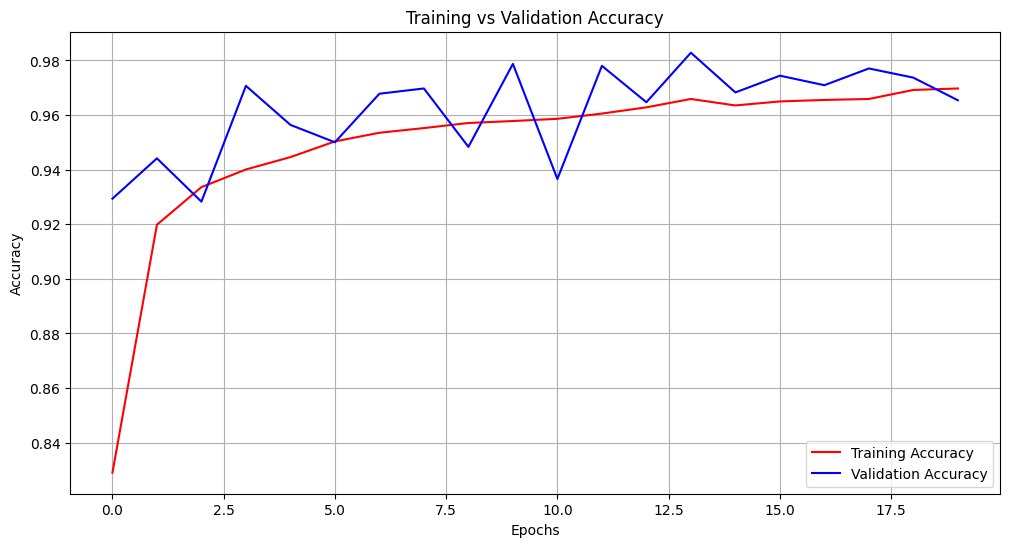

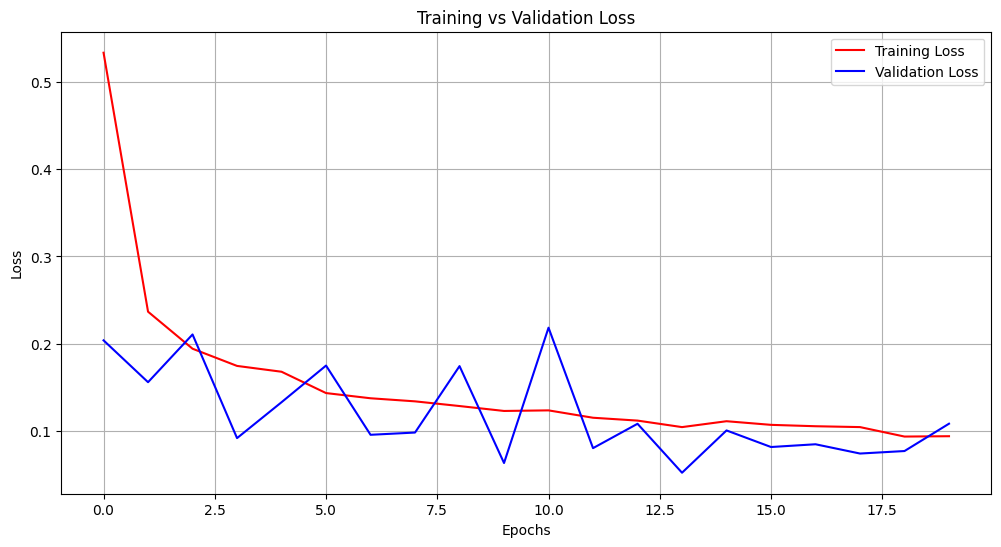

In [24]:
# Plot training and validation accuracy over epochs
get_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
get_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
epochs = range(len(get_acc))
plt.figure(figsize=(12, 6))
plt.plot(epochs, get_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, get_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [25]:
# Additional prediction analysis on the test set
pred2 = model.predict(test_features)
print(pred2.shape)

# Convert predictions to class labels
PRED = [np.argmax(item) for item in pred2]

# Print the count of each predicted class
print(pd.Series(PRED).value_counts())

434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
(13875, 37)
33    516
4     434
24    433
5     417
32    414
30    413
20    410
2     402
17    396
23    394
10    392
21    390
18    389
7     382
26    381
15    379
9     370
12    370
11    370
28    368
27    367
36    366
19    365
13    365
35    365
8     361
22    356
16    355
14    354
6     352
31    350
0     340
25    338
3     334
1     322
34    315
29    250
Name: count, dtype: int64


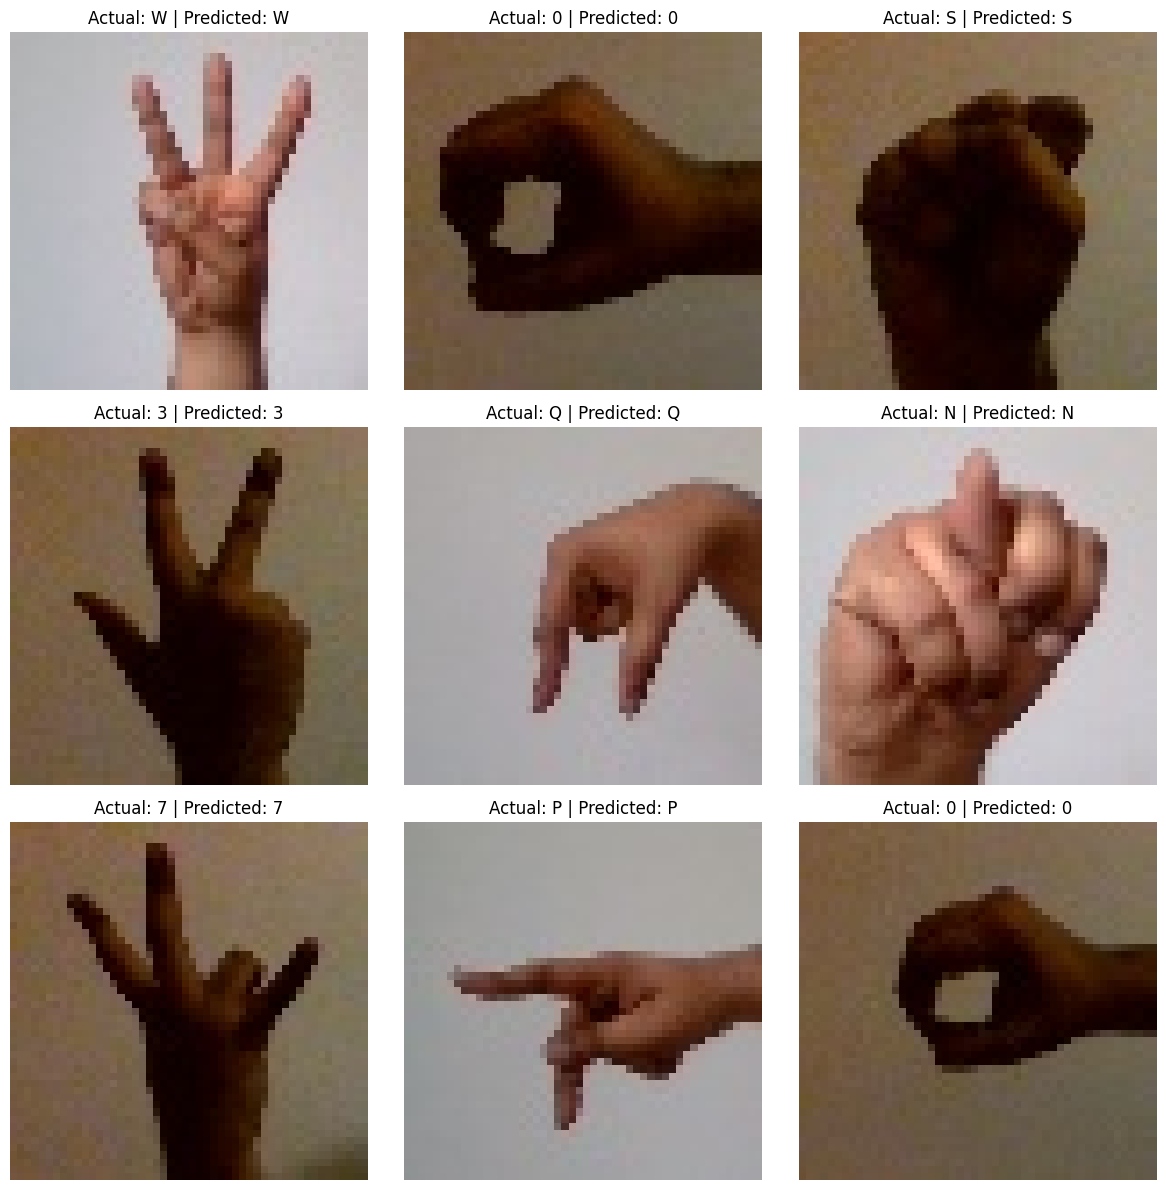

In [26]:
# Plot images with their actual and predicted labels
def plot_images_with_predictions(test_images, actual_labels, predicted_labels, reverse_mapping, num_images=9):
    """
    Plots a grid of images with their actual and predicted labels.
    
    Parameters:
    - test_images: Array of test images
    - actual_labels: Array of actual labels (indices)
    - predicted_labels: Array of predicted labels (indices)
    - reverse_mapping: Mapping from label indices to their corresponding class names
    - num_images: Number of images to display (default is 9)
    """
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    
    for i in range(min(num_images, len(test_images))):
        r = i // 3
        c = i % 3
        img = test_images[i]
        axs[r][c].axis("off")
        
        actual = reverse_mapping[actual_labels[i]]
        predict = reverse_mapping[predicted_labels[i]]    
        axs[r][c].set_title(f'Actual: {actual} | Predicted: {predict}')
        axs[r][c].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming you have reverse_mapping defined
plot_images_with_predictions(test_features, ground_truth, PRED, reverse_mapping, num_images=9)


In [27]:
# Check the shape of the prediction and the true labels
print("Shape of test_features:", test_features.shape)
print("Shape of test_labels_categorical:", test_labels_categorical.shape)
print("Shape of pred2:", pred2.shape)

# Ensure the prediction is for the same `test_features` used in train_test_split
pred5 = model.predict(test_features)  # Use test_features here, not testX
print("New shape of pred5:", pred5.shape)

# Convert predictions to class labels
PREDICT = [np.argmax(item) for item in pred5]

# Make sure `test_labels_categorical` is in the correct format (as class labels, not one-hot)
ground_truth = np.argmax(test_labels_categorical, axis=1)  # Convert one-hot to labels if needed


Shape of test_features: (13875, 50, 50, 3)
Shape of test_labels_categorical: (13875, 37)
Shape of pred2: (13875, 37)
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
New shape of pred5: (13875, 37)


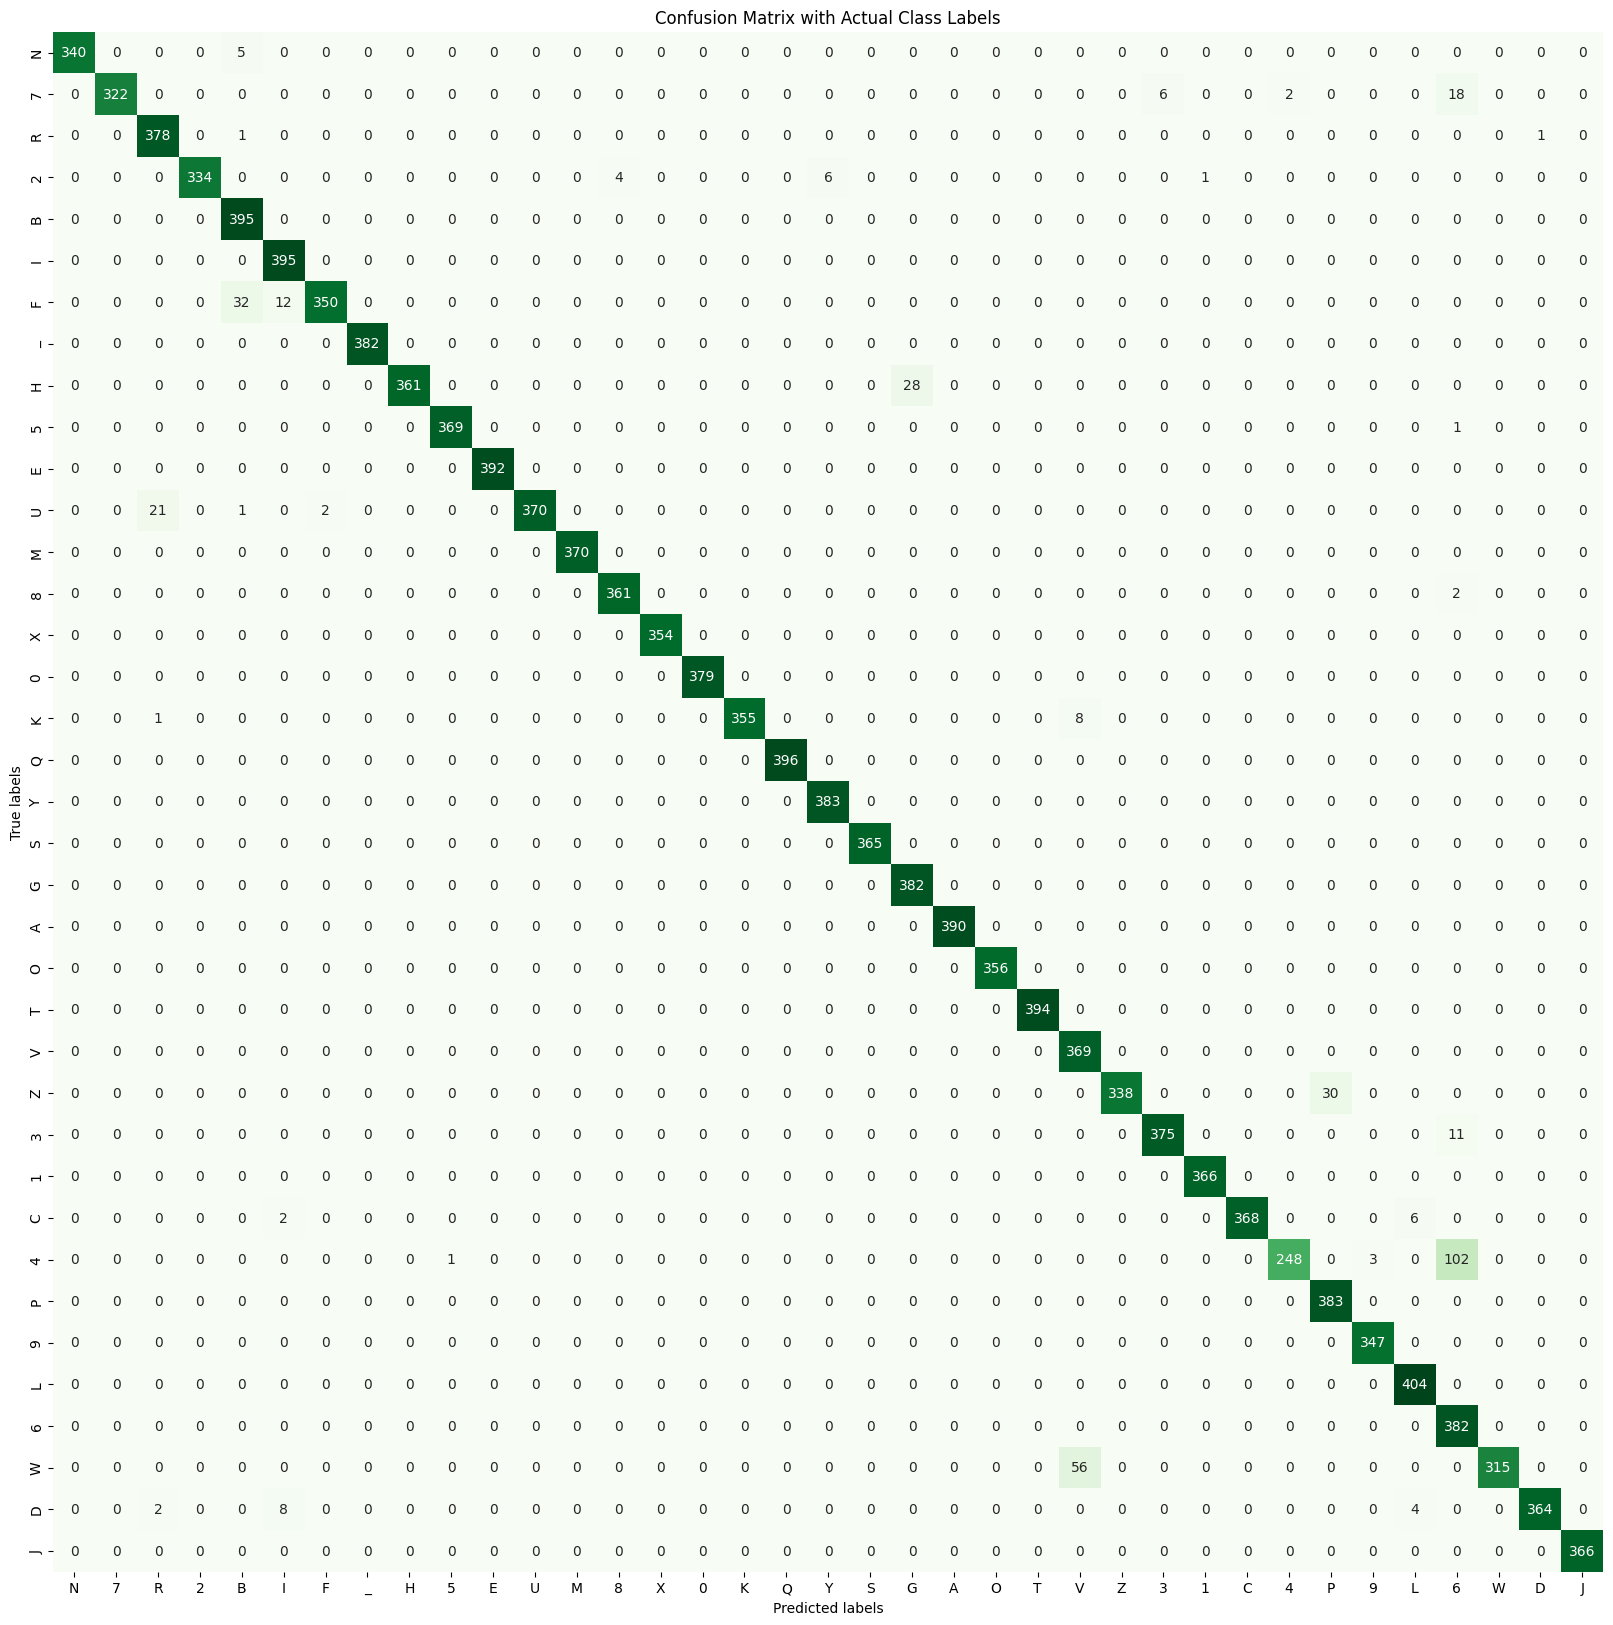

In [28]:
# Import necessary libraries for confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot the confusion matrix with mapped labels
def plot_confusion_matrix(Y_test, Y_pred, label_mapping):
    # Generate the confusion matrix
    cm = confusion_matrix(Y_test, Y_pred)
    
    # Convert numerical labels to actual class labels using reverse_mapping
    labels = [label_mapping[i] for i in range(len(label_mapping))]

    plt.figure(figsize=(20, 20))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='g', 
        cmap='Greens', 
        cbar=False, 
        xticklabels=labels, 
        yticklabels=labels
    )

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix with Actual Class Labels')
    plt.show()

# Call the function
# Assuming `ground_truth` is your test labels and `PREDICT` is your predicted labels
plot_confusion_matrix(ground_truth, PREDICT, reverse_mapping)


In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix

def convert_to_binary_confusion_matrix(y_true, y_pred, positive_classes):
    """
    Converts a multi-class confusion matrix into a 2x2 binary matrix.

    Parameters:
    - y_true: List or array of true labels.
    - y_pred: List or array of predicted labels.
    - positive_classes: List of class indices to consider as positive.

    Returns:
    - Binary confusion matrix as a 2x2 array.
    """
    # Convert multi-class labels to binary (1 for positive, 0 for negative)
    y_true_binary = [1 if label in positive_classes else 0 for label in y_true]
    y_pred_binary = [1 if label in positive_classes else 0 for label in y_pred]

    # Compute the binary confusion matrix
    return confusion_matrix(y_true_binary, y_pred_binary)

# Example Usage:
# Define positive classes (e.g., class 0 is positive, others are negative)
positive_classes = [0]  # Replace with the class(es) you want to treat as positive

# Assuming `ground_truth` and `PREDICT` are your lists of true and predicted labels
binary_cm = convert_to_binary_confusion_matrix(ground_truth, PREDICT, positive_classes)

# Print the binary confusion matrix
print("2x2 Binary Confusion Matrix:")
print(binary_cm)

2x2 Binary Confusion Matrix:
[[13530     0]
 [    5   340]]


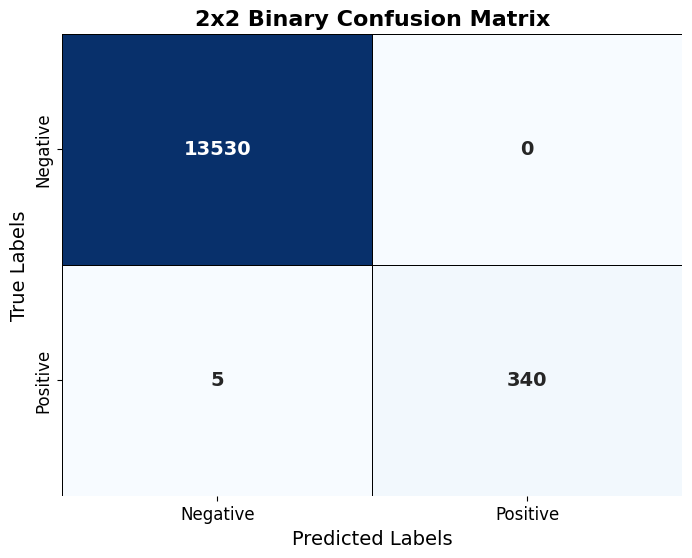

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_binary_confusion_matrix(y_true, y_pred, positive_classes, labels=["Negative", "Positive"]):
    """
    Plots a styled 2x2 binary confusion matrix.

    Parameters:
    - y_true: List or array of true labels.
    - y_pred: List or array of predicted labels.
    - positive_classes: List of class indices to consider as positive.
    - labels: List of string labels for the confusion matrix axes (default: ["Negative", "Positive"]).
    """
    # Convert multi-class labels to binary
    y_true_binary = [1 if label in positive_classes else 0 for label in y_true]
    y_pred_binary = [1 if label in positive_classes else 0 for label in y_pred]
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        cbar=False, 
        xticklabels=labels, 
        yticklabels=labels, 
        linewidths=0.5, 
        linecolor='black', 
        annot_kws={"size": 14, "weight": "bold"}
    )
    
    # Add titles and labels
    plt.title("2x2 Binary Confusion Matrix", fontsize=16, weight="bold")
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

# Example usage:
# Assuming `ground_truth` is your test labels and `PREDICT` is your predicted labels
positive_classes = [0]  # Replace with the class you want to treat as positive
plot_binary_confusion_matrix(ground_truth, PREDICT, positive_classes)

434/434 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step


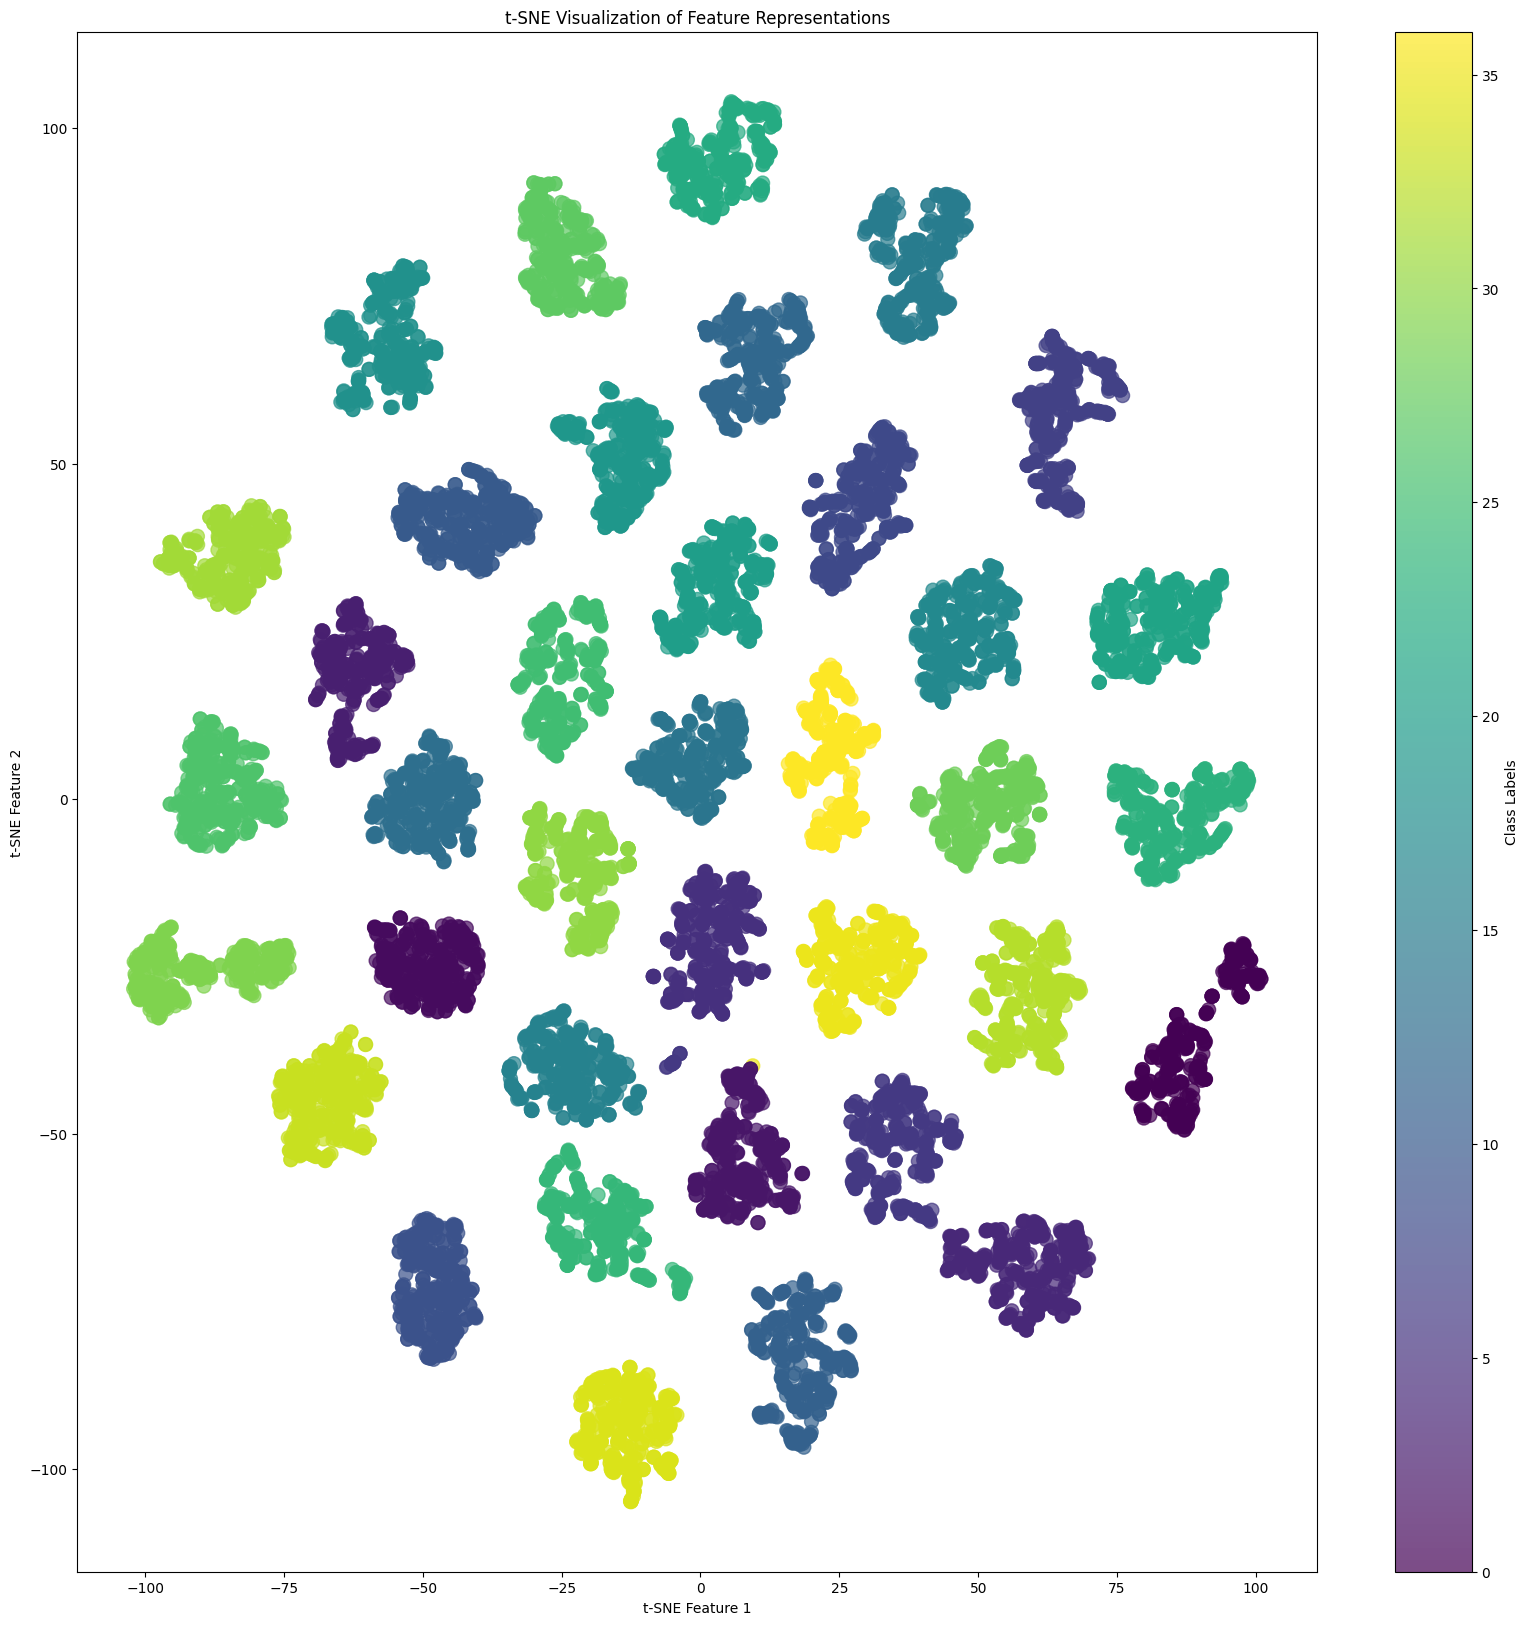

In [31]:
# Import t-SNE from sklearn
from sklearn.manifold import TSNE

# Step 1: Extract Features from the Model
# Define a new model to output features from the layer before the final Dense layer
# For example, if `x` is the second last layer, you can get features from there:
feature_extractor = tf.keras.Model(
    inputs=model.input, 
    outputs=model.layers[-2].output  # Choose the appropriate layer, e.g., the layer before softmax
)

# Step 2: Get Feature Representations
# Use test_features or another dataset to get the features
features = feature_extractor.predict(test_features)

# Step 3: Apply t-SNE to reduce dimensions to 2D
# Initialize t-SNE with appropriate parameters
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the features to 2D space
features_2d = tsne.fit_transform(features)

# Step 4: Visualize using a scatter plot
plt.figure(figsize=(20, 20))

# Create a scatter plot using the t-SNE features
# Use the `ground_truth` labels for coloring the points
scatter = plt.scatter(
    features_2d[:, 0],  # x-coordinates
    features_2d[:, 1],  # y-coordinates
    c=ground_truth,     # Use true labels to color points
    cmap='viridis',     # Change the colormap as needed
    s=100,              # Size of points
    alpha=0.7           # Transparency of points
)

# Add a color bar to show label mapping
plt.colorbar(scatter, label='Class Labels')

# Set title and axis labels
plt.title('t-SNE Visualization of Feature Representations')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()


In [32]:
from lime import lime_image

In [33]:
import matplotlib.cm as cm

# Function to generate a Grad-CAM heatmap for a single image
def generate_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        output = predictions[:, pred_index]

    # Check if prediction is valid
    if tf.reduce_max(predictions[0]) < 0.1:
        print("Model is not confident about the prediction. Skipping heatmap generation.")
        return None

    grads = tape.gradient(output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    conv_outputs = conv_outputs * pooled_grads[tf.newaxis, tf.newaxis, :]
    heatmap = tf.reduce_mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heatmap = np.max(heatmap)
    if max_heatmap == 0:
        max_heatmap = 1e-10
    heatmap /= max_heatmap

    return heatmap

In [34]:
# Function to generate and display Grad-CAM heatmaps for a list of images in subplots
def display_gradcam_heatmaps(model, heat_img_dir_array, last_conv_layer_name):
    superimposed_images = []
    image_titles = []
    for img_path in heat_img_dir_array:
        print(f"Processing image: {img_path}")
        try:
            # Load and preprocess the image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image at {img_path}. Skipping.")
                continue
            img = cv2.resize(img, (50, 50))
            img_array = np.expand_dims(img, axis=0) / 255.0

            # Generate the heatmap
            heatmap = generate_gradcam_heatmap(model, img_array, last_conv_layer_name)
            if heatmap is None:
                continue

            # Rescale heatmap to a range 0-255 for visualization
            heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
            heatmap_rescaled = np.uint8(255 * heatmap_resized)

            # Apply the heatmap to the original image
            jet = cm.get_cmap("jet")
            heatmap_colored = jet(heatmap_rescaled / 255.0)[:, :, :3]
            heatmap_colored = np.uint8(heatmap_colored * 255)
            superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

            # Convert BGR to RGB for matplotlib display
            superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

            # Append the image and title to lists
            superimposed_images.append(superimposed_img_rgb)
            image_titles.append(f"Grad-CAM Heatmap\n{img_path.split('/')[-2]}")

        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

    # Now display all images in subplots
    num_images = len(superimposed_images)
    if num_images == 0:
        print("No images to display.")
        return

    # Determine grid size
    cols = min(3, num_images)  # Maximum of 3 columns for better visibility
    rows = (num_images + cols - 1) // cols  # Compute number of rows needed

    plt.figure(figsize=(5 * cols, 5 * rows))
    for i, img in enumerate(superimposed_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(image_titles[i], fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Processing image: /kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/W/1.jpg


/tmp/ipykernel_30/3230647612.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


Processing image: /kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/O/1.jpg
Processing image: /kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/S/1.jpg
Processing image: /kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/3/1.jpg
Processing image: /kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/Q/1.jpg
Processing image: /kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/N/1.jpg
Processing image: /kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/P/1.jpg
Processing image: /kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/4/1.jpg
Processing image: /kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/F/1.jpg


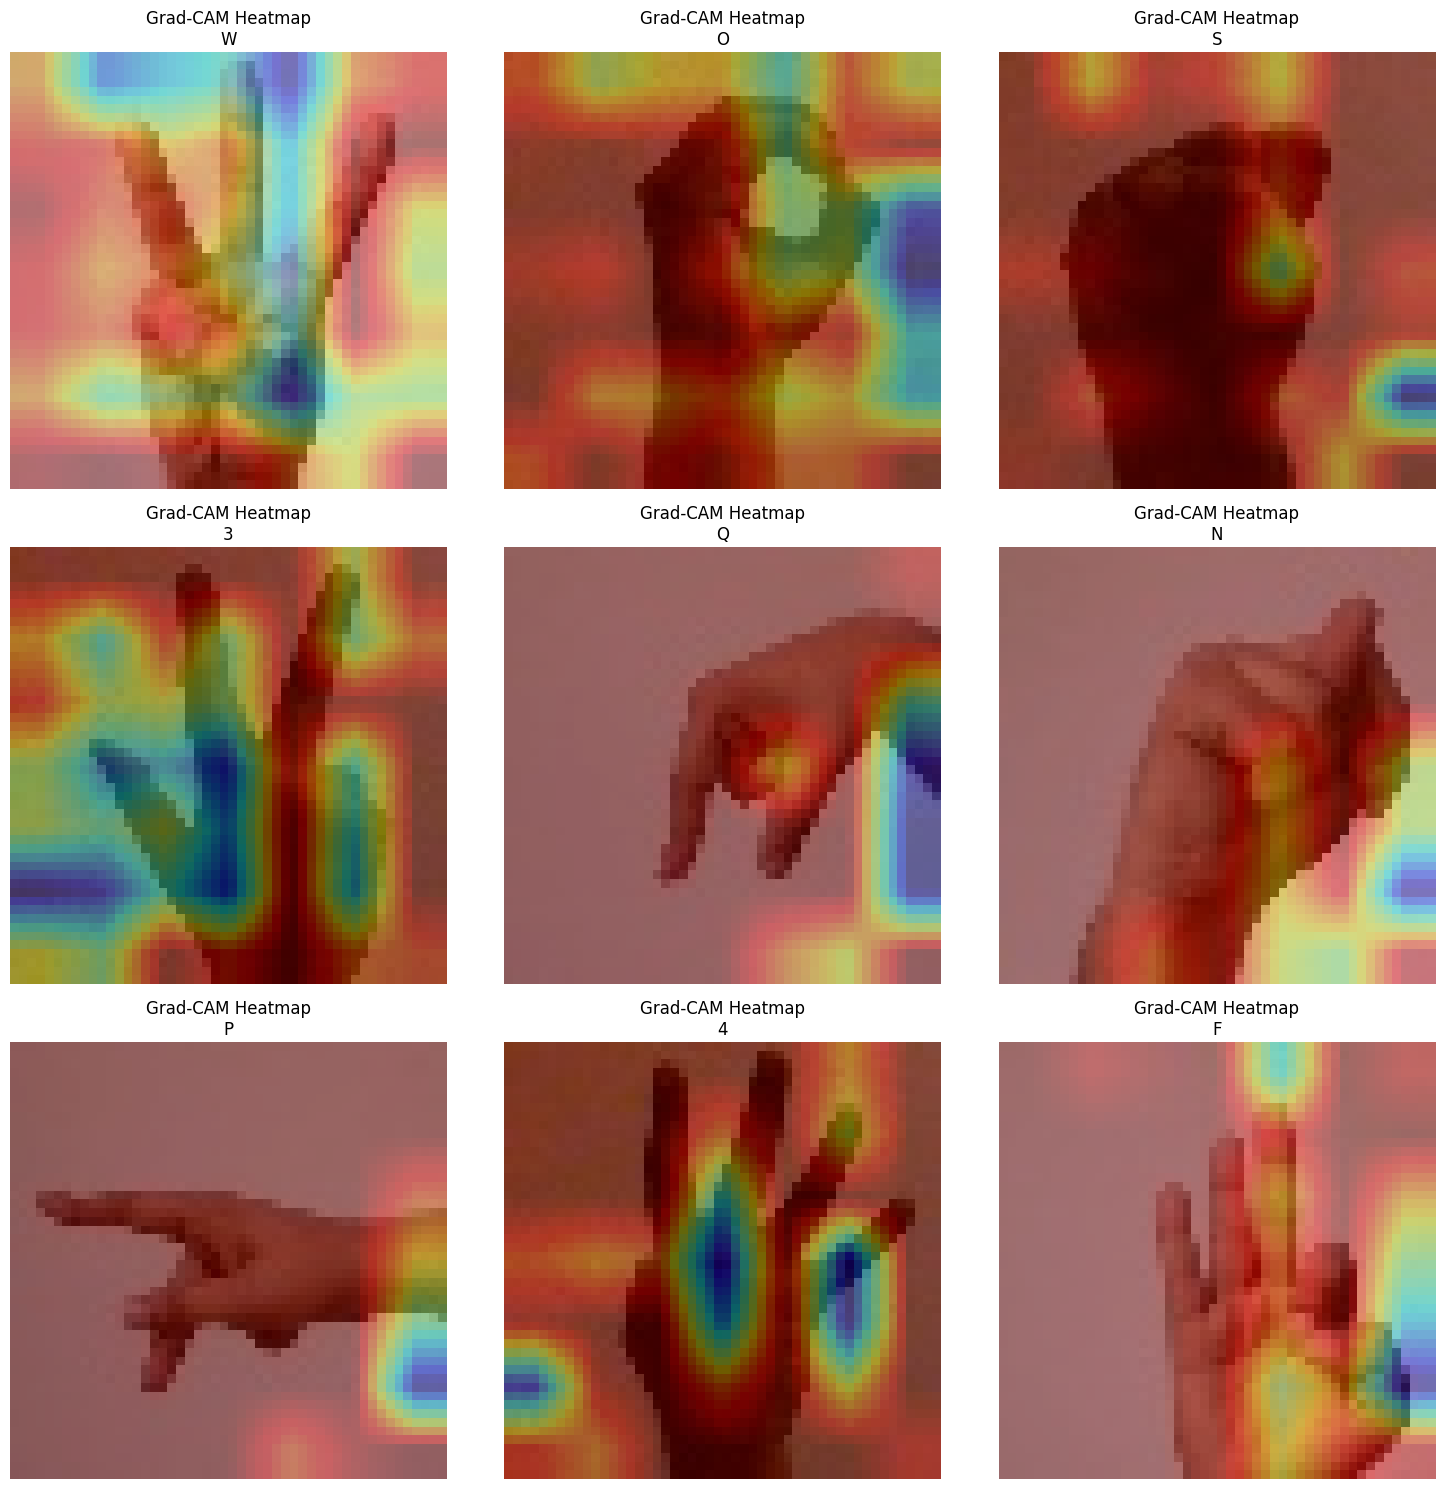

In [35]:
# Specify the name of an earlier convolutional layer
last_conv_layer_name = 'conv3_block4_2_conv'  # Replace with the correct layer name from model.summary()

# List of image paths to test
heat_img_dir_array = [
    '/kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/W/1.jpg',
    '/kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/O/1.jpg',
    '/kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/S/1.jpg',
    '/kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/3/1.jpg',
    '/kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/Q/1.jpg',
    '/kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/N/1.jpg',
    '/kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/P/1.jpg',
    '/kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/4/1.jpg',
    '/kaggle/input/sign-language-gesture-images-dataset/Gesture Image Data/F/1.jpg',
    # Add more image paths as needed
]

# Call the function to display Grad-CAM heatmaps
display_gradcam_heatmaps(model, heat_img_dir_array, last_conv_layer_name)

In [36]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 50, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 56, 56, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 25, 25,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 25, 25,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 25, 25,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 27, 27,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 13, 13,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 13, 13,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 13, 13,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 13, 13,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 13, 13,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 13, 13,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 13, 13,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 13, 13,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 13, 13,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 13, 13,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 13, 13,    │      1,024 │ conv2_block1_3_c

 Total params: 24,388,849 (93.04 MB)

 Trainable params: 267,045 (1.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 534,092 (2.04 MB)

In [37]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

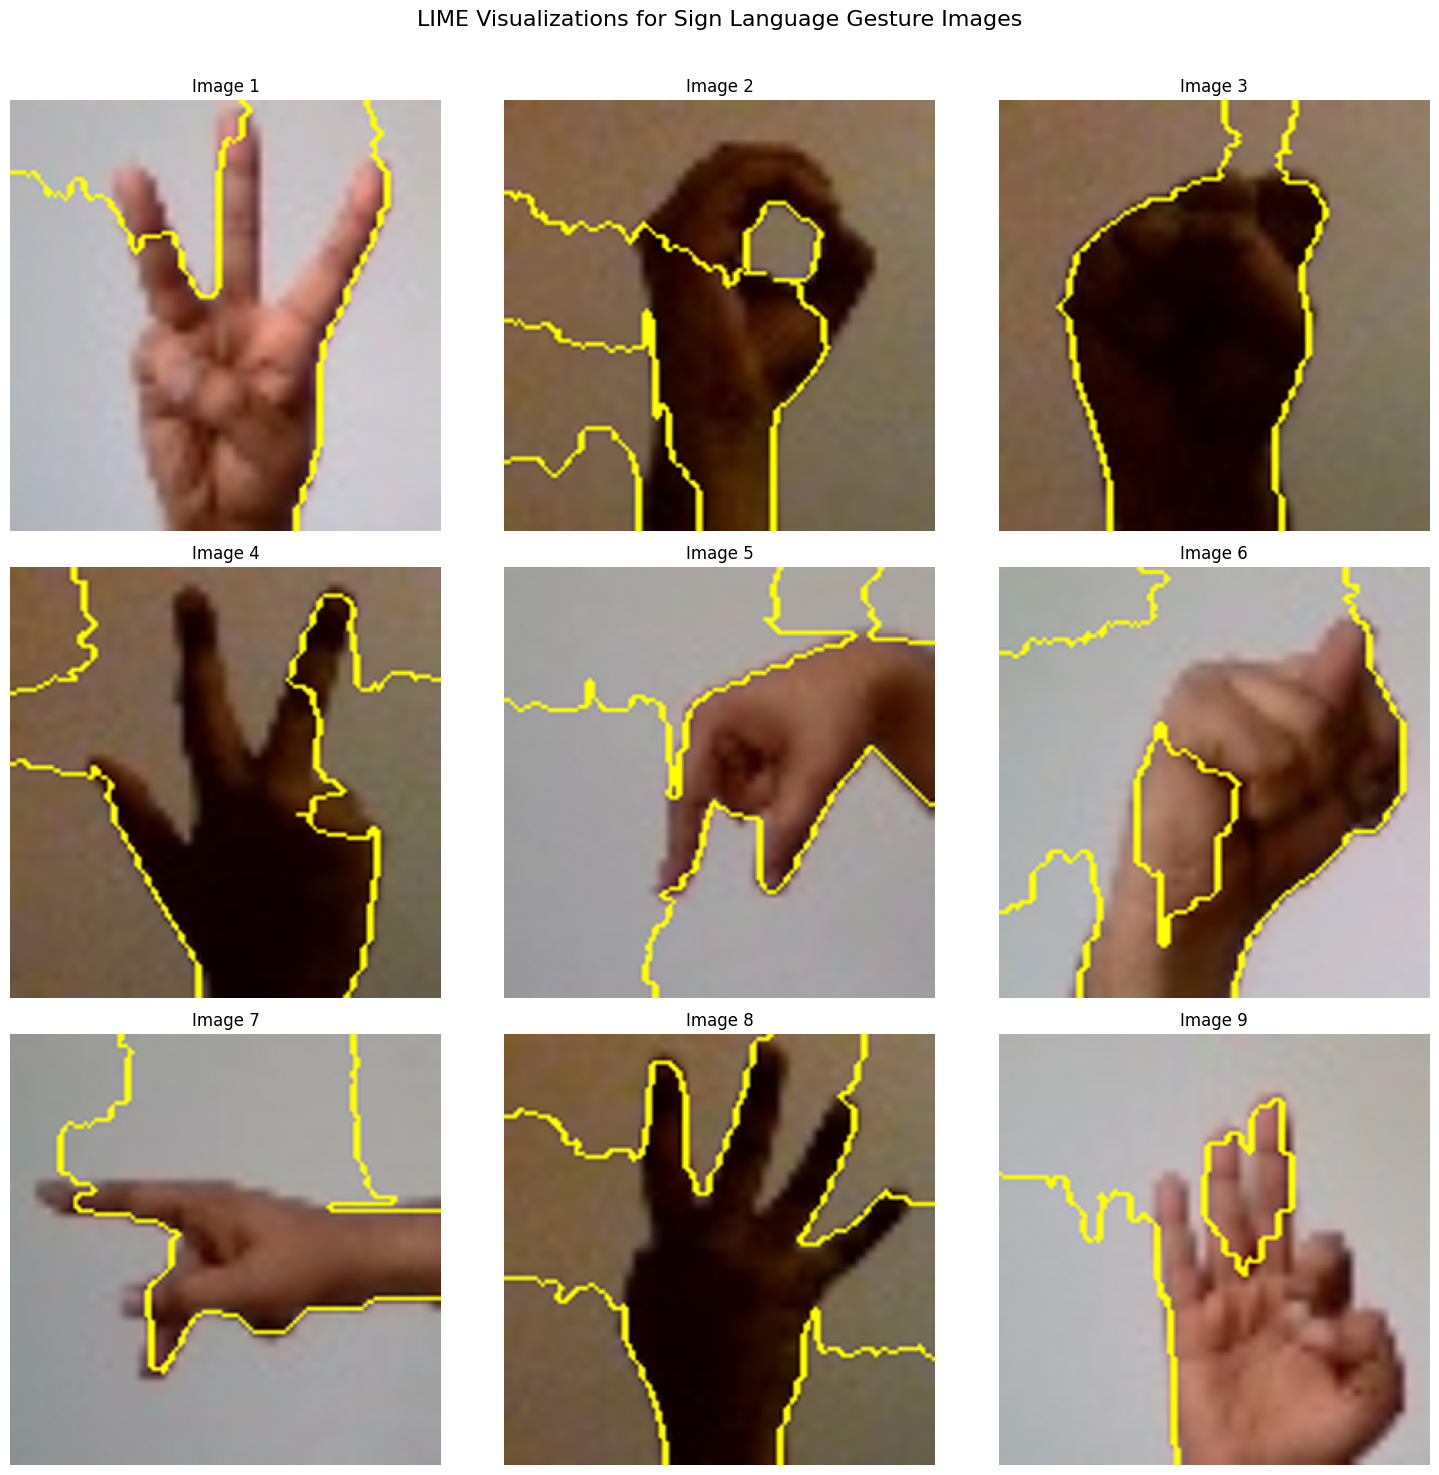

In [38]:
# Load and preprocess images
images = []
for img_path in heat_img_dir_array:
    image = cv2.imread(img_path)
    image = cv2.resize(image, (128, 128))  # Resize to a larger shape for better visualization
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    images.append(image)

images = np.array(images)

# Instantiate LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

# Define the function for LIME prediction
def predict_fn(images):
    # Resize images to model's input size (50, 50) for prediction
    resized_images = [cv2.resize(img, (50, 50)) for img in images]
    processed_images = np.array(resized_images, dtype=np.float32) / 255.0  # Normalize the images as per your training
    predictions = model.predict(processed_images)
    return predictions

# Set up the figure for 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('LIME Visualizations for Sign Language Gesture Images', fontsize=16)

# Generate LIME explanations for each image and plot
for idx, image in enumerate(images):
    # Get the explanation for the image
    explanation = explainer.explain_instance(
        image, 
        predict_fn, 
        top_labels=5, 
        hide_color=0, 
        num_samples=1000
    )
    
    # Predict label for the image
    processed_image = cv2.resize(image, (50, 50))[np.newaxis, ...] / 255.0  # Resize and normalize as per your training
    predicted_label = np.argmax(model.predict(processed_image))

    # Extract the image with the mask
    temp, mask = explanation.get_image_and_mask(
        label=predicted_label,  # Predict the label for the image
        positive_only=True,  # Show only positive contributions
        num_features=5,  # Use fewer features for clearer visualization
        hide_rest=False
    )
    
    # Mark boundaries before resizing the image
    image_with_boundaries = mark_boundaries(temp, mask)
    
    # Upscale the marked image to improve visualization quality
    upscaled_image = cv2.resize(image_with_boundaries, (300, 300), interpolation=cv2.INTER_CUBIC)
    
    # Plot the image with LIME explanation
    ax = axes[idx // 3, idx % 3]
    ax.imshow(upscaled_image)
    ax.set_title(f'Image {idx + 1}')
    ax.axis('off')

# Adjust layout and show the figure
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()